<a href="https://colab.research.google.com/github/vitorbdiniz/python-applied-to-finance/blob/main/Rebalanceamento_de_Carteiras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rebalanceamento de Portfólios

Continuando a saga de estudos sobre [Quant & Investimentos](https://tc.com.br/tc-school/quant-investimentos/) com o TC School, trataremos aqui sobre como montar um sistema Python de apoio ao seu portfólio de ações capaz de realizar rebalanceamento dos seus ativos a partir dos seguintes parâmetros:

- Pesos fixos;
- Beta;
- Volatilidade.


#Importando Bibliotecas Necessárias

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import statistics as st

import pandas_datareader as web
import matplotlib.pyplot as plt

#Declarando Funções Necessárias

In [ ]:
def patrimonio_total(portfolio):
  '''
      Calcula o patrimônio total do portfolio (DataFrame)
      retorna valor `float` do patrimônio
  '''
  patrimonio = 0
  for i in range(portfolio.shape[0]):
    patrimonio += portfolio["preços"].iloc[i]*portfolio["quantidades"].iloc[i]
  return patrimonio

In [ ]:
#Reorganização do dicionário para um DataFame, a fim de facilitar a visualização dos dados
def dic_to_df(data, col):
  df = pd.DataFrame(columns=list(data.values())[0]['ações'])
  for date in data.keys():
    df.loc[date] = data[date][col].tolist()
  return df

In [ ]:
#calcula pesos do portfólio
calcula_pesos = lambda portfolio : [ portfolio['quantidades'].iloc[i] * portfolio['preços'].iloc[i] / patrimonio_total(portfolio) if patrimonio_total(portfolio) > 0  else 0 for i in range(portfolio.shape[0])]
#Busca preços de um conjunto de ações para o intervalo de tempo informado em um frequência informada
busca_precos = lambda acoes, inicio, fim, ohlc='Adj Close',freq='D' : pd.DataFrame({acao : web.get_data_yahoo(acao+".SA", start=inicio, end=fim)[ohlc] if acao[0] != '^' else web.get_data_yahoo(acao, start=inicio, end=fim)[ohlc] for acao in acoes }).resample(freq).pad()
#Calcula retornos da série de preços
calcula_retornos = lambda precos : pd.Series([None] + [precos[i]/precos[i-1] -1 for i in range(1, len(precos))], index=precos.index)

# Por que rebalancear a carteira?

Suponha que, às 10h do dia 2 de janeiro de 2020, sua carteira hipotética é composta por 4 ativos com a distribuição de pesos a seguir:

In [ ]:
#Buscando preços para o dia 2020-12-30
acoes = ['MGLU3','BBAS3','KLBN11','CSAN3']
precos_jan = busca_precos(acoes, inicio='2020-01-02', fim='2020-01-02', ohlc='Open')

In [ ]:
portfolio_ilustrativo_jan = pd.DataFrame({'ações':acoes, 'preços':precos_jan.iloc[0].tolist(), 'quantidades':[2072,469,1350,354]})

portfolio_ilustrativo_jan["pesos"] = calcula_pesos(portfolio_ilustrativo_jan)
portfolio_ilustrativo_jan


,ações,preços,quantidades,pesos
0,MGLU3,12.075000,2072,0.307811
1,BBAS3,53.349998,469,0.307832
2,KLBN11,18.520000,1350,0.307597
3,CSAN3,17.625000,354,0.076761


Esperamos que ao não realizar rebalanceamento de carteira, seja obtida uma participação maior dos ativos com rentabilidade acima da média e menor participação daqueles abaixo da média. 

Mantendo, então, a quantidade de ações fixa (não comprando ou vendendo quaisquer ativos) obtemos a seguinte composição para o portfólio no dia 30 de dezembro de 2020:

In [ ]:
#Buscando preços para o dia 2020-12-30
precos_dez = busca_precos(acoes, inicio='2020-12-30', fim='2020-12-30')

In [ ]:
portfolio_ilustrativo_dez = pd.DataFrame({'ações':acoes, 'preços':precos_dez.iloc[0].tolist(), 'quantidades':[2072,469,1350,354]})

portfolio_ilustrativo_dez["pesos"] = calcula_pesos(portfolio_ilustrativo_dez)
portfolio_ilustrativo_dez


,ações,preços,quantidades,pesos
0,MGLU3,24.950001,2072,0.462503
1,BBAS3,37.551670,469,0.157564
2,KLBN11,26.549999,1350,0.320666
3,CSAN3,18.713688,354,0.059268


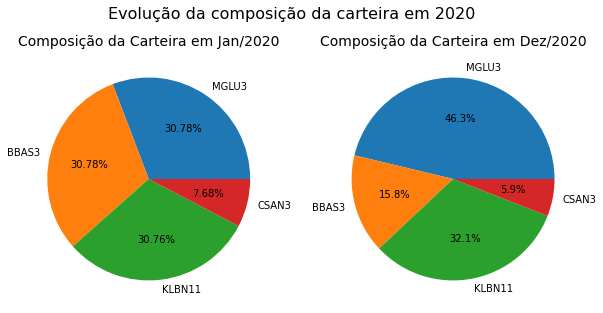

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Evolução da composição da carteira em 2020', size=16)

ax[0].pie(portfolio_ilustrativo_jan['pesos'], labels=portfolio_ilustrativo_jan['ações'], autopct='%1.2f%%')
ax[0].set_title('Composição da Carteira em Jan/2020', size=14)

ax[1].pie(portfolio_ilustrativo_dez['pesos'], labels=portfolio_ilustrativo_dez['ações'], autopct='%1.1f%%')
ax[1].set_title('Composição da Carteira em Dez/2020', size=14)
plt.show()

In [ ]:
print("Rentabilidades em 2020: \n")
retornos = pd.Series((portfolio_ilustrativo_dez['preços'] / portfolio_ilustrativo_jan['preços'] -1).values, index=portfolio_ilustrativo_dez['ações'].tolist())
print(retornos)
print("\nRetorno médio {:.4f}".format(np.average(retornos.tolist(), weights=portfolio_ilustrativo_jan["pesos"].tolist())))

Rentabilidades em 2020: 

MGLU3     1.066253
BBAS3    -0.296126
KLBN11    0.433585
CSAN3     0.061770
dtype: float64

Retorno médio 0.3752


Os resultados confirmam a hipótese formulada: os ativos com rentabilidades acima da média (MGLU3 e KLBN11) obtiveram um alargamento em suas participações, já os de retorno abaixo da média (BBAS3 e CSAN3) sofreram um encolhimento.

Sabendo disso, vamos agora implementar 3 métodos para rebalancear carteiras. 

#Rebalanceamento de Portfólio

##Pesos fixos

A forma mais simples de rebalancear um portfólio é fixando os pesos para cada ativo e mantê-los com as participações desejadas.

Com isso, consideramos que desejamos criar uma carteira da seguinte forma:

In [ ]:
portfolio_inicial = pd.DataFrame({'ações':acoes, 'preços':precos_jan.iloc[0].tolist(), 'pesos_desejados': [0.25, 0.25, 0.25, 0.25], 'quantidades':[0,0,0,0]})

portfolio_inicial["pesos_reais"] = calcula_pesos(portfolio_inicial)
portfolio_inicial

,ações,preços,pesos_desejados,quantidades,pesos_reais
0,MGLU3,12.075000,0.25,0,0
1,BBAS3,53.349998,0.25,0,0
2,KLBN11,18.520000,0.25,0,0
3,CSAN3,17.625000,0.25,0,0


*Para* balancear a carteira criaremos a seguinte função:

In [ ]:
def balanceamento_pesos_fixos(portfolio, patrimonio = None):
  if patrimonio is None:
    patrimonio = patrimonio_total(portfolio)
  quantidades = []
  pesos_reais = []
  variacao_n_acoes = []
  variacao_dos_pesos = []
  for i in range(portfolio.shape[0]):
    capital_disponivel = portfolio['pesos_desejados'].iloc[i] * patrimonio
    quantidade_nova = int(capital_disponivel/portfolio['preços'].iloc[i])
    peso_novo = quantidade_nova*portfolio['preços'].iloc[i] / patrimonio
    
    quantidades.append(quantidade_nova)
    pesos_reais.append(peso_novo)
    
    variacao_n_acoes.append(quantidade_nova - portfolio['quantidades'].iloc[i])
    variacao_dos_pesos.append(peso_novo - portfolio['pesos_reais'].iloc[i])
  
  portfolio_balanceado = portfolio.copy()
  portfolio_balanceado['quantidades'] = quantidades
  portfolio_balanceado['pesos_reais'] = pesos_reais
  portfolio_balanceado['variação_ações'] = variacao_n_acoes
  portfolio_balanceado['variação_pesos'] = variacao_dos_pesos
  return portfolio_balanceado


Para fazer o primeiro balanceamento, deve-se passar o seu patrimônio total como parâmetro, o qual supomos que seja de R$ 100 mil.

In [ ]:
portfolio = balanceamento_pesos_fixos(portfolio_inicial, patrimonio = 100000)
portfolio

,ações,preços,pesos_desejados,quantidades,pesos_reais,variação_ações,variação_pesos
0,MGLU3,12.075000,0.25,2070,0.249952,2070,0.249952
1,BBAS3,53.349998,0.25,468,0.249678,468,0.249678
2,KLBN11,18.520000,0.25,1349,0.249835,1349,0.249835
3,CSAN3,17.625000,0.25,1418,0.249922,1418,0.249922


A função "balanceamento", recebe o portfólio e o patrimônio, altera as quantidades de ações e os pesos para os valores mais próximos dos desejados e indica as variações ocorridas. Por exemplo, havia 0 ações KLBN11, foram adicionadas 1349 (variação_ações), totalizando 1349 (quantidades).

Implementaremos, agora, um rebalanceamento mensal (antes do pregão de abertura do mês) durante todo o ano de 2020 do portfólio acima. 

In [ ]:
def rebalanceamento_mensal_pesos_fixos(portfolio, inicio=dt.date(2020,1,1), fim=dt.date(2020,12,31)):
  portfolio = portfolio.copy()

  portfolios = dict()
  portfolios[inicio] = portfolio.copy()
  precos = busca_precos(portfolio["ações"], inicio, fim, freq='M') #'M' para mensal. Para ver mais opções de frequências, veja a documentação https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html

  for periodo in precos.index:
    portfolio['preços'] = precos.loc[periodo].tolist()
    portfolio["pesos_reais"] = calcula_pesos(portfolio)
    portfolio = balanceamento_pesos_fixos(portfolio)
    portfolios[periodo] = portfolio.copy()
  return portfolios


Em seguida, aplicamos a função:

In [ ]:
portfolios = rebalanceamento_mensal_pesos_fixos(portfolio, inicio=dt.date(2020,1,1), fim=dt.date(2020,12,31))

Por fim, devemos observar que as participações das ações estão constantes mês a mês no portfólio, entretanto, as quantidades devem sofrer alterações para alcançar o peso estipulado.

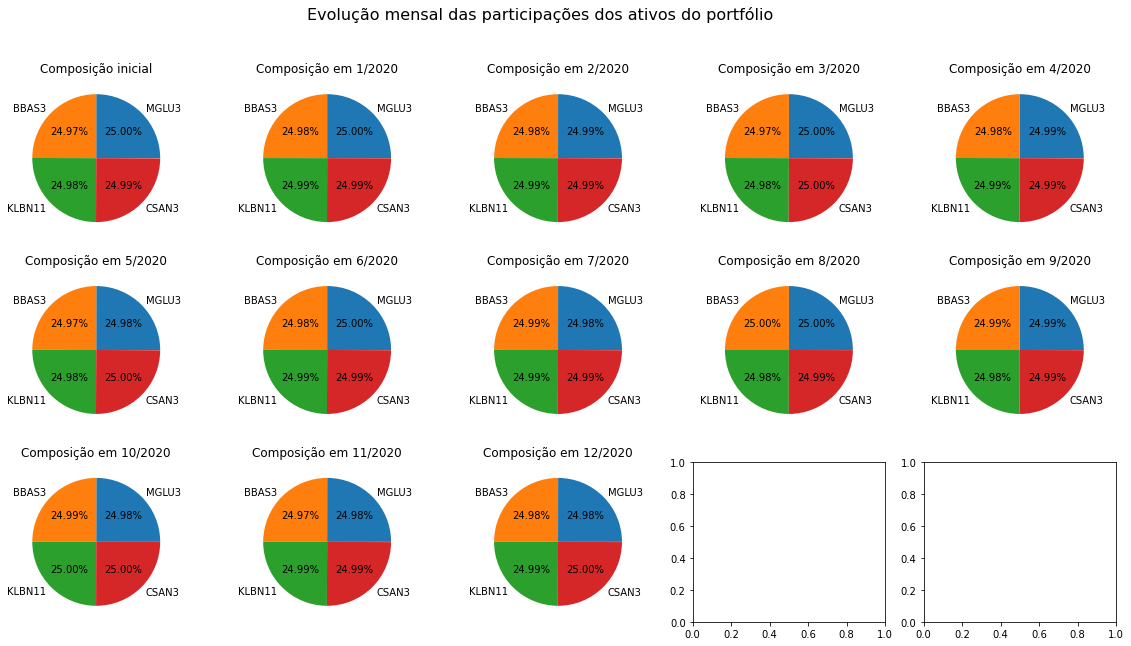

In [ ]:
nrows=3
ncols=5
fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
fig.suptitle('Evolução mensal das participações dos ativos do portfólio', size=16)

i,j=0,0
for date in portfolios.keys():
  ax[(i,j)].pie(portfolios[date]['pesos_reais'], labels=portfolios[date]['ações'], autopct='%1.2f%%')
  if date == dt.date(2020,1,1):
    ax[(i,j)].set_title(f'Composição inicial')  
  else:
    ax[(i,j)].set_title(f'Composição em {date.month}/{date.year}')

  j+=1
  if j == ncols:
    i+=1
    j=0
plt.show()


In [ ]:
evolucao_mensal = dic_to_df(portfolios, 'quantidades')

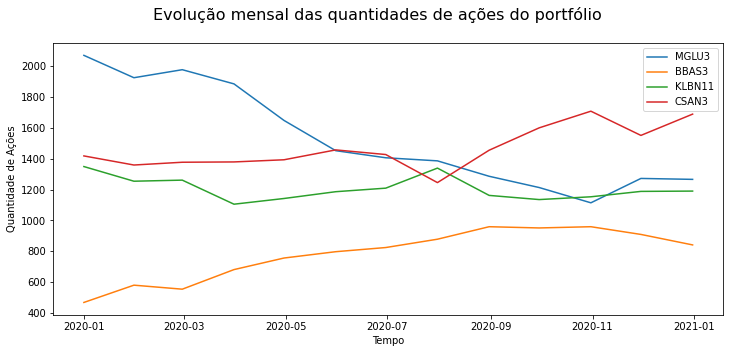

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
fig.suptitle('Evolução mensal das quantidades de ações do portfólio', size=16)

for acao in evolucao_mensal.columns:
  ax.plot(evolucao_mensal[acao], label=acao)
ax.set_ylabel('Quantidade de Ações')
ax.set_xlabel('Tempo')

plt.legend()
plt.show()


##Beta

Vamos supor agora que seu portfólio seja composto pelas mesmas ações, contudo, sua preocupação não será em manter os pesos por ativo fixos, mas o beta.

Como discutido em [Calculando o Beta em Python](https://tc.com.br/tc-school/quant-investimentos/python-calcular-beta), o beta da carteira é calculado através da razão entre a covariância dos retornos do portfólio com os do mercado e a variância dos retornos do mercado, conforme ilustrado na figura abaixo. 

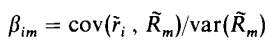


Dessa forma, é primordial implementar funções que calculem o beta:
* Para um único ativo;
* Para uma série de ativos; 
* Para o portfólio.

In [ ]:
beta_ativo = lambda retornos_ativo, retornos_mercado : np.cov(retornos_ativo, retornos_mercado)[0][1] / st.variance(retornos_mercado)

def beta_ativos_portfolio(portfolio, date=dt.date(2020,1,1), num_dias_corridos = 365, force=False):
  '''
      Calcula o beta para cada ativo do portfólio no intervalo [date-num_dias_corridos, date]
  '''
  if not force and 'betas' in portfolio.columns:
    betas = portfolio['betas']
  else:
    precos = busca_precos(['^BVSP']+portfolio['ações'].tolist(), inicio = date - dt.timedelta(days=num_dias_corridos), fim=date)
    retornos = pd.DataFrame({ativos : calcula_retornos( precos[ativos] ) for ativos in precos }).dropna()
    betas = pd.Series([beta_ativo(retornos[r], retornos['^BVSP']) for r in retornos.columns if r != '^BVSP'], index=retornos.drop(columns='^BVSP').columns)
  return betas

def beta_portfolio(portfolio, date=dt.date(2020,1,1), num_dias_corridos = 365):
  if 'betas' in portfolio.columns:
    betas = portfolio['betas']  
  else: 
    betas = beta_ativos_portfolio(portfolio, date, num_dias_corridos)   
  
  if sum(portfolio['pesos'].tolist()) > 0:
    beta = np.average(betas.tolist(), weights=portfolio['pesos'].tolist()) 
  else:
    beta = 0
  return beta


In [ ]:
date = dt.date(2020,1,1)
portfolio_inicial = pd.DataFrame({'ações':acoes, 'preços':precos_jan.iloc[0].tolist(), 'quantidades':[0,0,0,0]})

portfolio_inicial["pesos"] = calcula_pesos(portfolio_inicial)
portfolio_inicial['betas'] = beta_ativos_portfolio(portfolio_inicial, date, num_dias_corridos = 365).tolist()
portfolio_inicial

,ações,preços,quantidades,pesos,betas
0,MGLU3,12.075000,0,0,1.175489
1,BBAS3,53.349998,0,0,1.337301
2,KLBN11,18.520000,0,0,0.543271
3,CSAN3,17.625000,0,0,1.015543


Agora já temos os betas de cada ativo. Com isso, o próximo passo é definir uma função (`converge_to_average`) para cálculo dos pesos a partir dos betas dos ativos e do beta desejado. Para tanto, será utilizada uma técnica de machine learning para redução de erro [1] de minimizar a distância entre o beta do portfólio e o beta desejado.


O código obedece o seguinte algoritmo:

* Inicializa-se portfólio com pesos iguais (neste caso, 0.25 ou 25%);
* Entra em loop até convergência ou até limite de repetições;
 * Calcula-se o erro percentual entre os betas (desejado e portfólio);
 * Ajusta pesos com base no erro calculado, nas distâncias entre os betas dos ativos e o desejado e na taxa de aprendizagem
* Normaliza dados para garantir que a soma dos pesos seja 1;


In [ ]:
def converge_to_average(array, target, weights=None, learning_rate=0.1, err_ref=0.001, max_iter=1000):
  if weights is None:
    weights = np.array([1/len(array)]*len(array))

  iter_counter = 0
  error = 10000
  while abs(error) > err_ref and iter_counter < max_iter:
    avg = np.average(array, weights=weights)
    error = target / avg -1

    weights = adjust_weights(array,weights, target, error, learning_rate=learning_rate)
    iter_counter += 1
  weights = normalize(weights)
  return weights


In [ ]:
def distances(array, xbar=None):
  if xbar is None:
    xbar = st.mean(array)
  dist = array - xbar
  return dist

def adjust_weights(array, weights, target, error, learning_rate=0.1):
  dist = distances(array, target)
  return weights + error*dist*learning_rate

def normalize(array):
  return array/sum(array)

Com o cálculo de ajuste de pesos implementado, o próximo passo é balancear a carteira:

In [ ]:
def rebalanceamento_por_beta(portfolio, beta_desejado, patrimonio=None, weights=None, date=dt.date(2020,1,1), num_dias_corridos = 365):
  if patrimonio is None:
    patrimonio = patrimonio_total(portfolio)
  portfolio = portfolio.copy()
  betas = beta_ativos_portfolio(portfolio, date, num_dias_corridos, force=True).values

  portfolio['pesos'] = converge_to_average(betas,beta_desejado, weights=weights)
  portfolio['quantidades'] = (patrimonio*portfolio['pesos']/portfolio['preços']).astype(int)
  portfolio['betas'] = betas

  return portfolio

Aplicando o rebalanceamento para montar o portfólio inicial, obtemos:

In [ ]:
beta_desejado=0.87
portfolio = rebalanceamento_por_beta(portfolio_inicial, beta_desejado=beta_desejado, patrimonio = 100000)
print(f'Beta desejado: {beta_desejado:.4f}\nBeta real: {beta_portfolio(portfolio):.4f}')

Beta desejado: 0.8700
Beta real: 0.8708


In [ ]:
portfolio

,ações,preços,quantidades,pesos,betas
0,MGLU3,12.075000,1525,0.184167,1.175489
1,BBAS3,53.349998,218,0.116570,1.337301
2,KLBN11,18.520000,2420,0.448278,0.543271
3,CSAN3,17.625000,1424,0.250985,1.015543


Com o algoritmo de rebalanceamento por beta montado, podemos observar o comportamento do portfólio no prazo de 1 ano.

In [ ]:
def rebalanceamento_mensal_beta(portfolio, beta_desejado, num_dias_corridos = 365, inicio=dt.date(2020,1,1), fim=dt.date(2020,12,31)):
  portfolio = portfolio.copy()

  portfolios = dict()
  portfolios[inicio] = portfolio.copy()

  precos = busca_precos(portfolio["ações"], inicio, fim, freq='M')
  for date in precos.index:
    portfolio['preços'] = precos.loc[date].tolist()
    portfolio = rebalanceamento_por_beta(portfolio, beta_desejado, weights=portfolio['pesos'].values,date=date, num_dias_corridos=num_dias_corridos)
    portfolios[date] = portfolio.copy()

  return portfolios


In [ ]:
portfolios = rebalanceamento_mensal_beta(portfolio, beta_desejado=0.87, num_dias_corridos = 720)

Agora podemos visualizar os dados que foram gerados:

In [ ]:
#Reorganização do dicionário para DataFames, a fim de facilitar a visualização dos dados
evolucao_mensal_pesos = dic_to_df(portfolios, 'pesos')
evolucao_mensal_betas = dic_to_df(portfolios, 'betas')
betas_portfolio = pd.Series({date:beta_portfolio(portfolios[date]) for date in portfolios})

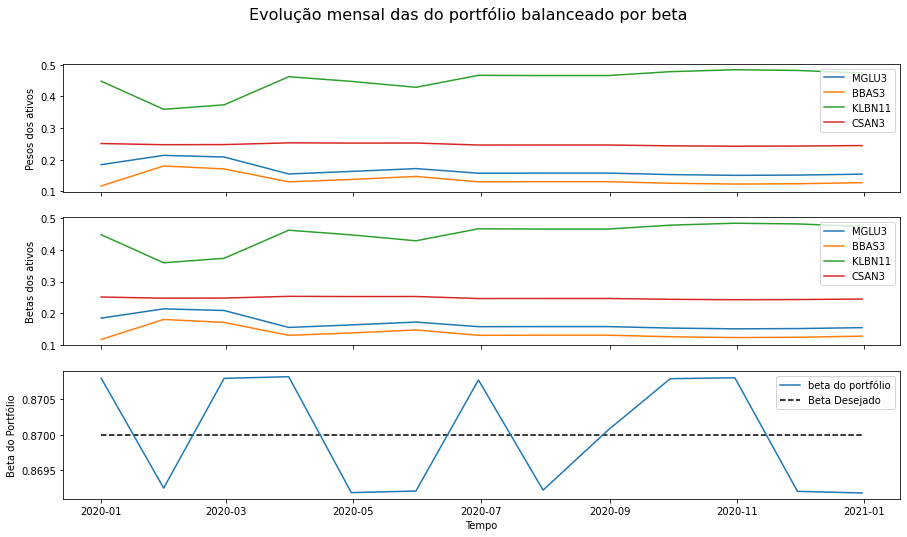

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,8))
fig.suptitle('Evolução mensal das do portfólio balanceado por beta', size=16)

for acao in evolucao_mensal_pesos:
  ax[0].plot(evolucao_mensal_pesos[acao], label=acao)
ax[0].set_ylabel('Pesos dos ativos')
ax[0].legend()

for acao in evolucao_mensal_pesos:
  ax[1].plot(evolucao_mensal_pesos[acao], label=acao)
ax[1].set_ylabel('Betas dos ativos')
ax[1].legend()

ax[2].plot(betas_portfolio, label="beta do portfólio")
ax[2].hlines(y=beta_desejado, xmin=betas_portfolio.index[0], xmax=betas_portfolio.index[-1], label='Beta Desejado', linestyles='dashed')
ax[2].set_ylabel('Beta do Portfólio')
ax[2].set_xlabel('Tempo')
ax[2].legend()


plt.show()


Por fim, observamos que as participações das ações variam conforme a oscilação dos seus respectivos betas a fim de manter o beta do portfólio estável.

##Volatilidade

Outra forma de rebalancear carteiras é estipulando uma taxa de volatilidade desejada. Como discutido em [Avaliando performance de portfólios com o Python](https://tc.com.br/tc-school/quant-investimentos/python-analise-acoes), a volatilidade de uma carteira é comumente calculado através do desvio padrão.

Com isso, utilizaremos o mesmo algoritmo utilizado na seção do Beta, alterando apenas o cálculo para o desvio padrão.


In [ ]:
def volatilidade_ativos(portfolio, date=dt.date(2020,1,1), num_dias_corridos = 365):
    precos = busca_precos(portfolio['ações'].tolist(), inicio = date - dt.timedelta(days=num_dias_corridos), fim=date)
    retornos = pd.DataFrame({ativos : calcula_retornos( precos[ativos] ) for ativos in precos }).dropna()
    volatilidade = retornos.std()
    return volatilidade

def volatilidade_portfolio(portfolio, date=dt.date(2020,1,1), num_dias_corridos = 365):
  if 'volatilidade' in portfolio.columns:
    volatilidade = portfolio['volatilidade']  
  else:
    volatilidade = volatilidade_ativos(portfolio, date, num_dias_corridos)
  
  if sum(portfolio['pesos'].tolist()) > 0:
    volatilidade = np.average(volatilidade.tolist(), weights=portfolio['pesos'].tolist()) 
  else:
    volatilidade = 0
  return volatilidade

Portfólio inicial:

In [ ]:
date = dt.date(2019,1,1)
portfolio_inicial = pd.DataFrame({'ações':acoes, 'preços':precos_jan.iloc[0].tolist(), 'quantidades':[0,0,0,0]})

portfolio_inicial["pesos"] = calcula_pesos(portfolio_inicial)
portfolio_inicial['volatilidade'] = volatilidade_ativos(portfolio_inicial, date=date, num_dias_corridos = 365).values
portfolio_inicial

,ações,preços,quantidades,pesos,volatilidade
0,MGLU3,12.075000,0,0,0.025113
1,BBAS3,53.349998,0,0,0.021624
2,KLBN11,18.520000,0,0,0.011520
3,CSAN3,17.625000,0,0,0.018588


In [ ]:
def rebalanceamento_por_vol(portfolio, vol_desejada, patrimonio=None, weights=None, date=dt.date(2019,1,1), num_dias_corridos = 365):
  if patrimonio is None:
    patrimonio = patrimonio_total(portfolio)
  portfolio = portfolio.copy()
  vol = volatilidade_ativos(portfolio, date, num_dias_corridos).values

  portfolio['pesos'] = converge_to_average(vol,vol_desejada, weights=weights, learning_rate=0.01, err_ref=0.001, max_iter=5000)
  portfolio['quantidades'] = (patrimonio*portfolio['pesos']/portfolio['preços']).astype(int)
  portfolio['volatilidade'] = vol

  return portfolio

Primeiro balanceamento:

In [ ]:
vol_desejada=0.02
portfolio = rebalanceamento_por_vol(portfolio_inicial, vol_desejada=vol_desejada, patrimonio = 100000)
print(f'Volatilidade desejada: {vol_desejada:.4f}\nVolatilidade real: {volatilidade_portfolio(portfolio):.4f}')

Volatilidade desejada: 0.0200
Volatilidade real: 0.0194


In [ ]:
portfolio

,ações,preços,quantidades,pesos,volatilidade
0,MGLU3,12.075000,2158,0.260671,0.025113
1,BBAS3,53.349998,476,0.254363,0.021624
2,KLBN11,18.520000,1274,0.236092,0.011520
3,CSAN3,17.625000,1412,0.248873,0.018588


In [ ]:
def rebalanceamento_mensal_vol(portfolio, vol_desejada, num_dias_corridos = 365, inicio=dt.date(2019,1,1), fim=dt.date(2019,12,31)):
  portfolio = portfolio.copy()

  portfolios = dict()
  portfolios[inicio] = portfolio.copy()

  precos = busca_precos(portfolio["ações"], inicio, fim, freq='M')
  for date in precos.index:
    portfolio['preços'] = precos.loc[date].tolist()
    portfolio = rebalanceamento_por_vol(portfolio, vol_desejada,weights=portfolio['pesos'], date=date, num_dias_corridos=num_dias_corridos)
    portfolios[date] = portfolio.copy()
  return portfolios

Rebalanceamento mensal:

In [ ]:
portfolios = rebalanceamento_mensal_vol(portfolio, vol_desejada=0.02, num_dias_corridos = 365)

In [ ]:
#Reorganização do dicionário para DataFames, a fim de facilitar a visualização dos dados
evolucao_mensal_pesos = dic_to_df(portfolios, 'pesos')
evolucao_mensal_vol = dic_to_df(portfolios, 'volatilidade')
vol_portfolio = pd.Series({date:volatilidade_portfolio(portfolios[date]) for date in portfolios})

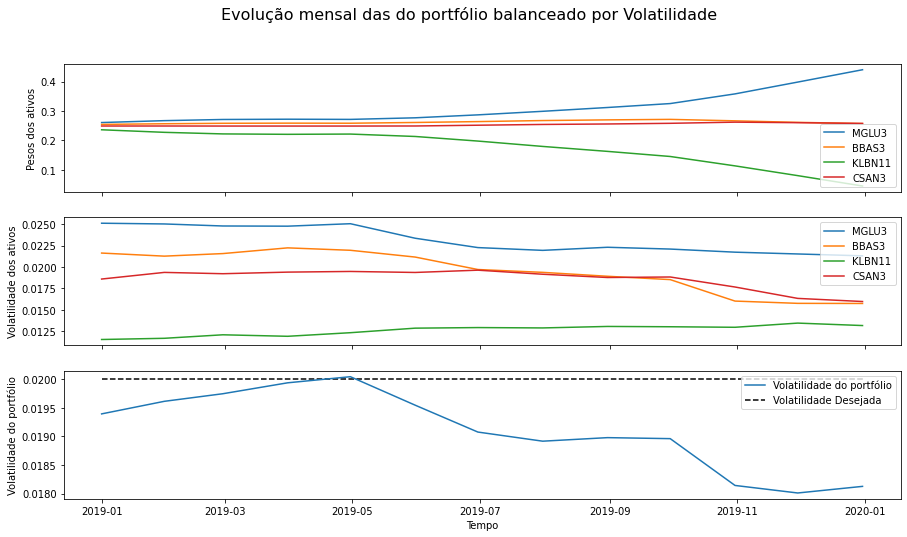

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,8))
fig.suptitle('Evolução mensal das do portfólio balanceado por Volatilidade', size=16)

for acao in evolucao_mensal_pesos:
  ax[0].plot(evolucao_mensal_pesos[acao], label=acao)
ax[0].set_ylabel('Pesos dos ativos')
ax[0].legend()

for acao in evolucao_mensal_pesos:
  ax[1].plot(evolucao_mensal_vol[acao], label=acao)
ax[1].set_ylabel('Volatilidade dos ativos')
ax[1].legend()

ax[2].plot(vol_portfolio, label="Volatilidade do portfólio")
ax[2].hlines(y=vol_desejada, xmin=vol_portfolio.index[0], xmax=vol_portfolio.index[-1], label='Volatilidade Desejada', linestyles='dashed')
ax[2].set_ylabel('Volatilidade do portfólio')
ax[2].set_xlabel('Tempo')
ax[2].legend()


plt.show()


#Conclusão



É possível, com esses conhecimentos, montar um sistema de rebalanceamento voltado para a sua carteira por três métodos. Sugiro ao leitor que copie este notebook para o Drive e que mude os parâmetros para verificar o comportamento do código em diversas situações.

#Disclaimer

* Este material é produzido e distribuído somente com os propósitos de informar e educar, e representa o estado do mercado na data da publicação, sendo que as informações estão sujeitas a mudanças sem aviso prévio;

* Este material não constitui declaração de fato ou recomendação de investimento ou para comprar, reter ou vender quaisquer títulos ou valores mobiliários. 

* O usuário não deve utilizar as informações disponibilizadas como substitutas de suas habilidades, julgamento e experiência ao tomar decisões de investimento ou negócio. 

* Essas informações não devem ser interpretadas como análise ou recomendação de investimentos e não há garantia de que o conteúdo apresentado será uma estratégia efetiva para os seus investimentos e, tampouco, que as informações poderão ser aplicadas em quaisquer condições de mercados. 

* Investidores não devem substituir esses materiais por serviços de aconselhamento, acompanhamento ou recomendação de profissionais certificados e habilitados para tal função. 

* Antes de investir, por favor considere cuidadosamente a sua tolerância ou a sua habilidade para riscos. 

Referências

[1] JAMES, Gareth et al. An introduction to statistical learning. New York: springer, 2013.

[2] [TC School: Calculando o Beta em Python](https://tc.com.br/tc-school/quant-investimentos/python-calcular-beta)

[3] [TC School: Avaliando performance de portfólios com o Python](https://tc.com.br/tc-school/quant-investimentos/python-analise-acoes)